# Statistics Canada Analysis: Investment Income

## Summary

The goal of this analysis is to investigate the economic family's investment income, where the true class indicates money was made on investments, and the false class indicates breaking even or money lost. The report examines its relationship with family size, the economic family's major income earner, the income after tax, and other related variables to determine whether or not its possible to predict it using those variables or a subset of them. The data is obtained from Statistics Canada's 2017 Canadian Income Survey [1]. 

## Introduction

It is estimated that roughly 39% of Canadians invest in stocks, putting Canada in 6th place among 16 countries for share of retail investors [2]. As every generation makes their first investments earlier than their predecessors [3], the importance of gauging and predicting the success of said investments arises.

Families of most wealth levels and sizes have been steadily placing an emphasis on maintaining passive income and generational wealth, through a variety of ways that range from real estate ownership to family offices [4].
In this analysis, we are particularly interested in the family size and its relationship to the investment income.

The economic family is defined by Statistics Canada as "a group of two or more persons who live in the same dwelling and are related to each other by blood, marriage, common-law union, adoption or a foster relationship" [5]. 

We will examine the investment income of the economic family with the aim of identifying whether or not we can predict it using the economic family size and the major income earner. 

There are other variables of interest that may also be useful in the context of the predictive analysis. We hypothesize that the average number of weekly working hours for the major source of income, their highest level of education and their income after tax may affect the economic family's investment income. Furthermore, the economic family's income after tax may be a strong candidate as a predictor variable, although there are some reservations due to it possibly being too collinear with the investment income. 

## Research Question

- How do economic family size and the major income earner in a family influence familial investment income outcome, where the true class indicates money was made on investments, and the false class indicates breaking even or money lost.

    - It should be noted that the question initially aimed to predict the numerical value of the investment, but the accuracy obtained showed a regression problem to be unsuitable (see report), so the problem was altered to a classification problem.

## Dataset Description

Canadian Income Survey (CIS) is a cross-sectional survey sponsored both by the Government of Canada and Statistics Canada. The purpose of this survey is to collect information from all Canadian citizens and households. However, around 2% of the residents in reserve aboriginal settlements or small population, extremely remote areas are not included in this survey. The data was collected with several different characteristics in mind including labour market activity, school attendance, disability, support payments, child care expenses, inter-household transfers. It also combines some information from the Labour Force Survey (LFS), such as the information about the education level and geography. This data set is available to all organizations, different levels of the government, and individuals. Different government levels could use this dataset to make economic well policies to all Canadians.

### Description of Relevent Variables

The original dataset contains 194 variables. However, our analysis is only concerned with 8, narrowed down using the aforementioned studies and assumptions. The description contains only those specified variables.

Description of the Relevant Variables:  

* EFSIZE: The number of economic family members: It is numeric, discrete and has a range of 1-7. 

* USHRWK: The average weekly working hours in the year. It is a numeric variable.

* ATINC: The total annual income before tax for each sampling unit. It is numeric, continuous, and has a range of -70395 to 825710.

* HLEV2G: The highest education level for each sampling unit. It is discrete and categorical, but represented with a number code. 

    * 1: Less than high school graduation
    * 2: Graduated high school or partial postsecondary education
    * 3: Non-university postsecondary certificate or diploma
    * 4: University degree or certificate
    * 6: Valid skip
    * 9: Not stated
    

* EFINVA: The total investment income. It is a numeric and continuous variable. It also includes the net partnership income and net rental income.  

* EFMJIE: A binary variable, representing whether or not the individual is the Major income earner of the economic family.

* EFATINC: The total annual income after tax for each economic family. It is numeric, with a range of -39850 to 1128860.

* EFMJSI: A discrete, categorical variable, which represents the major source of income for each economic family. The levels are represented using a number code.
    * 01: No income
    * 02: Wages and salaries
    * 03: Self-employment income
    * 04: Government transfers
    * 05: Investment income 
    * 06: Retirement pensions
    * 07: Other income

# Preliminary Analysis

### Loading the Data

In [1]:
# Importing the appropriate packages
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder,OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, cross_validate
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import Ridge, RidgeCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

import sys
sys.path.append('..')
from src.analysis.format_histograms import format_histograms
from src.analysis.alpha_tuning import ridge_alpha_tuning
from src.analysis.KNN_tuning import KNN_tuning
from src.analysis import inv_outcome_plot
from src.analysis.split_drop import split_drop

In [2]:
np.random.seed(1)

In [3]:
# Loading the data
data = pd.read_csv('../data/CIS-72M0003-E-2017-Annual/CIS-72M0003-E-2017-Annual_F1.csv')
data.head()

,YEAR,PUMFID,PERSONID,FWEIGHT,PROV,USZGAP,MBMREGP,AGEGP,SEX,MARST,...,DWLTYP,DWTENR,REPA,SUIT,MORTG,MORTGM,CONDMP,RENTM,CHNEED,VERDATE
0,2017,2129,212901,NaN,24,8,18,4,2,6,...,1,1,3,1,2,99999996,99999996,99999996,2,02JUL2019
1,2017,2129,212902,NaN,24,8,18,4,1,6,...,1,1,3,1,2,99999996,99999996,99999996,2,02JUL2019
2,2017,2129,212903,NaN,24,8,18,10,2,2,...,1,1,3,1,2,99999996,99999996,99999996,2,02JUL2019
3,2017,2129,212904,NaN,24,8,18,10,1,2,...,1,1,3,1,2,99999996,99999996,99999996,2,02JUL2019
4,2017,2130,213001,NaN,12,5,7,16,1,1,...,1,1,2,1,2,99999996,99999996,99999996,6,02JUL2019


### Cleaning and Wrangling

The data is reduced to some specific features and targets of interest before EDA, using the studies around the research question to narrow them down from 194 features to the most relevent 8.

In [4]:
reduced_data = data[['EFSIZE', 'USHRWK', 'ATINC', 'HLEV2G', 'EFINVA', 'EFMJIE', 'EFATINC', 'EFMJSI']]

### Visualisations 

#### Table 1: The Variables of Interest

In [5]:
reduced_data

,EFSIZE,USHRWK,ATINC,HLEV2G,EFINVA,EFMJIE,EFATINC,EFMJSI
0,4,NaN,12075,1,375,2,132440,3
1,4,NaN,10530,1,375,2,132440,3
2,4,NaN,6250,2,375,2,132440,3
3,4,NaN,103585,2,375,1,132440,3
4,2,NaN,69570,3,850,1,71815,6
...,...,...,...,...,...,...,...,...
92287,7,NaN,99999996,6,0,2,53300,4
92288,7,NaN,99999996,6,0,2,53300,4
92289,7,NaN,99999996,6,0,2,53300,4
92290,2,NaN,35255,3,0,1,51685,3


In [6]:
reduced_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92292 entries, 0 to 92291
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   EFSIZE   92292 non-null  int64  
 1   USHRWK   0 non-null      float64
 2   ATINC    92292 non-null  int64  
 3   HLEV2G   92292 non-null  int64  
 4   EFINVA   92292 non-null  int64  
 5   EFMJIE   92292 non-null  int64  
 6   EFATINC  92292 non-null  int64  
 7   EFMJSI   92292 non-null  int64  
dtypes: float64(1), int64(7)
memory usage: 5.6 MB


- All variables have a numeric type, but not all of them are quantitative.

- EFMJIE, EFMJSI, and HLEV2G  are categorical variables with levels represented as discrete numeric values.


In [7]:
reduced_data.describe()

,EFSIZE,USHRWK,ATINC,HLEV2G,EFINVA,EFMJIE,EFATINC,EFMJSI
count,92292.000000,0.0,9.229200e+04,92292.000000,92292.000000,92292.000000,9.229200e+04,92292.000000
mean,2.958848,NaN,1.836557e+07,3.340268,5722.896351,1.553439,8.712786e+04,2.861949
std,1.451516,NaN,3.867862e+07,1.711394,29041.941551,0.497139,5.858689e+04,1.337363
min,1.000000,NaN,-7.039500e+04,1.000000,-64000.000000,1.000000,-3.985000e+04,2.000000
25%,2.000000,NaN,2.102375e+04,2.000000,0.000000,1.000000,4.749000e+04,2.000000
50%,3.000000,NaN,4.114750e+04,3.000000,0.000000,2.000000,7.629000e+04,2.000000
75%,4.000000,NaN,8.203625e+04,4.000000,400.000000,2.000000,1.134400e+05,4.000000
max,7.000000,NaN,1.000000e+08,9.000000,960000.000000,2.000000,1.128860e+06,7.000000


- Although the USHRWK column is relevant to our analysis, the dataset has 0 zero valid entries. This is due to all values being NaN. This was also expressed in the dataset guide provided by Statistics Canada []. The remaining columns have a complete count of valid entries. (all non-null counts at 92292 which is in line with the number of total observations in the data) including the valid skip.

- The ATINC column contains the value 99999996 for observations that were skipped for the information for valid reasons. Therefore, these observations should be removed. 

In [8]:
reduced_data = reduced_data.drop(columns = 'USHRWK')

In [9]:
reduced_data = reduced_data.loc[reduced_data['ATINC'] != 99999996]

#### Table 2: Dataset w/o invalid observations for ATINC column.

In [10]:
reduced_data

,EFSIZE,ATINC,HLEV2G,EFINVA,EFMJIE,EFATINC,EFMJSI
0,4,12075,1,375,2,132440,3
1,4,10530,1,375,2,132440,3
2,4,6250,2,375,2,132440,3
3,4,103585,2,375,1,132440,3
4,2,69570,3,850,1,71815,6
...,...,...,...,...,...,...,...
92282,2,29540,1,1725,1,42235,4
92283,7,51000,1,0,1,53300,4
92284,7,2300,1,0,2,53300,4
92290,2,35255,3,0,1,51685,3


#### Figure 1: Frequency Distributions of the chosen variables

array([<AxesSubplot:title={'center':'Number of economic family members'}, xlabel='Number of People', ylabel='Frequency'>,
       <AxesSubplot:title={'center':'After Tax Income'}, xlabel='Dollars [CAD]', ylabel='Frequency'>,
       <AxesSubplot:title={'center':'Highest level of education of person'}, xlabel='Highest level of education', ylabel='Frequency'>,
       <AxesSubplot:title={'center':'EF Investment Income'}, xlabel='Dollars [CAD]', ylabel='Frequency'>,
       <AxesSubplot:title={'center':'Major Income earner in the economic Family'}, xlabel='Major income earner', ylabel='Frequency'>,
       <AxesSubplot:title={'center':'EF After-Tax Income'}, xlabel='Dollars [CAD]', ylabel='Frequency'>,
       <AxesSubplot:title={'center':'Major Source of income for the economic family'}, xlabel='Major source of income', ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>, <AxesSubplot:>], dtype=object)

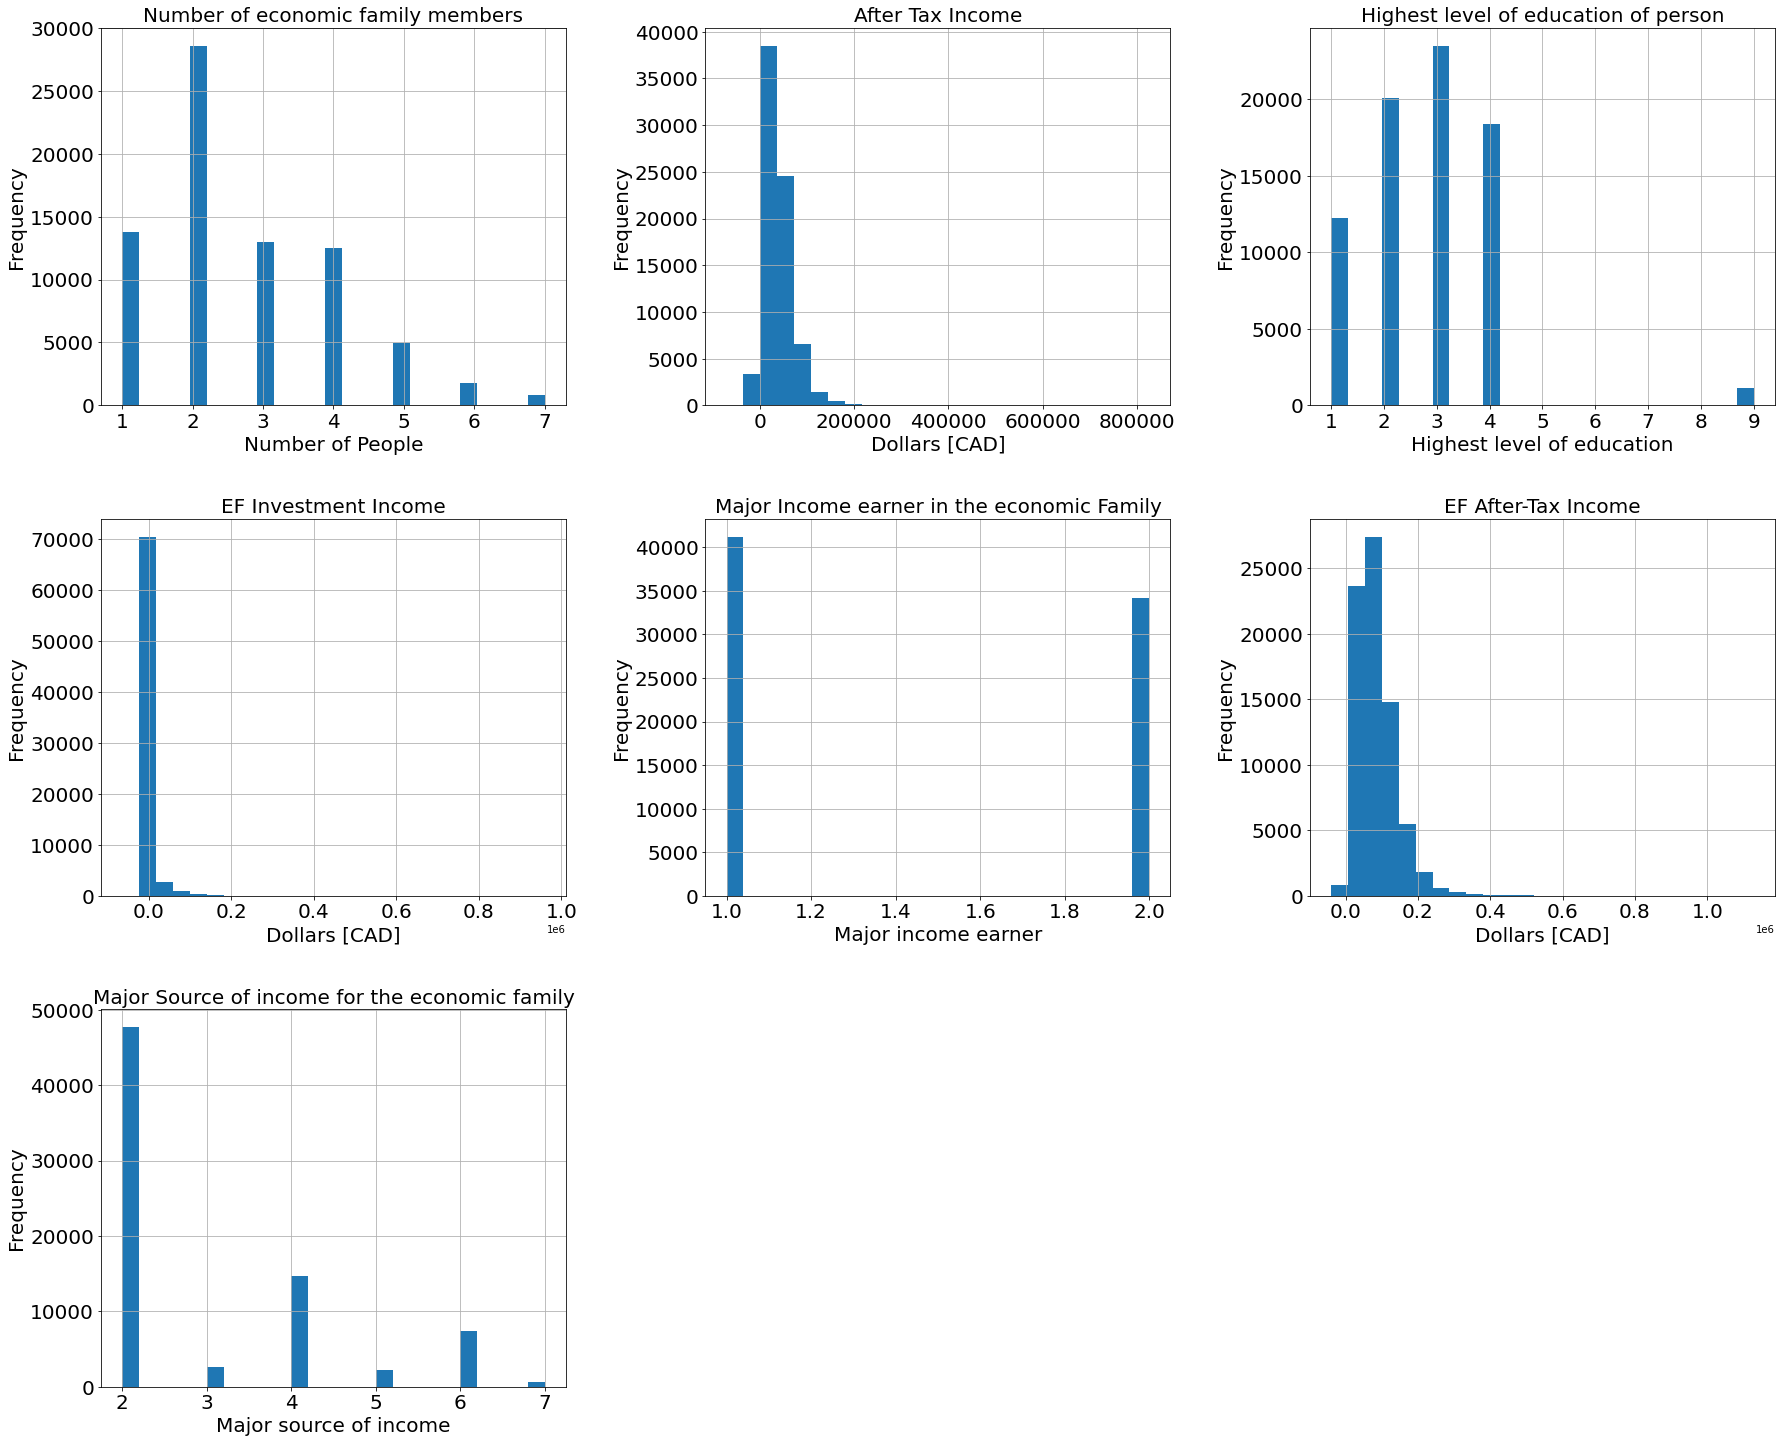

In [11]:
texts = { 'titles':['Number of economic family members', 
                    'After Tax Income',
                    'Highest level of education of person',
                    'EF Investment Income',
                    'Major Income earner in the economic Family',
                    'EF After-Tax Income',
                    'Major Source of income for the economic family',
                    ''],
            'xaxes':['Number of People',
                        'Dollars [CAD]',
                        'Highest level of education',
                        'Dollars [CAD]',
                        'Major income earner',
                        'Dollars [CAD]',
                        'Major source of income',
                        '']
         }
histograms = format_histograms(reduced_data, texts)
histograms

##### Comments on the figure

- Most observations have 2 economic family members, 

- After tax income for both individuals and the economic family shows a distribution with a slight skew to the left. 

- Investment income for the economic family shows a similar distribution to that of the after tax income, which could be a derivative of their potential multicollinearity (Investment income is a part of the total income before tax).

- Most economic families have salaries and wages as their major source of income. As this mode is relatively very large, it may indicate a lack of suitability as a predictor variable for the investment income if a large majority of the surveyed have the same source of income. 

- Upon further examination, the education level and the after tax income for individuals will not be used in the further analysis as they are variables relating to the individual and not the economic family as a whole. The lack of interesting trends in the graphs make it so that there is little sense in including them as predictors.


In [12]:
plt.figure(figsize=(10,10))
correlations = reduced_data.iloc[:,[1,3,5]].corr()

<Figure size 720x720 with 0 Axes>

#### Figure 2: Matrix of correlations between various features. 
##### Note: correlations between categorical features should be ignored as these are invalid

<AxesSubplot:>

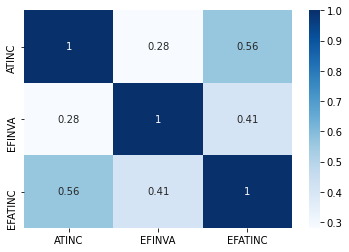

In [13]:
sns.heatmap(correlations, cmap=plt.cm.Blues, annot=True)

##### Comments on the figure

- ATINC shows a moderate to strong correlation to EFATINC, which can be explained by them representing the same quantity but the former relates to the individual as opposed to the latter's economic family.

- EFINVA shows a moderate to weak correlation with EFATINC. This is unexpected as we did not foresee the tax removal from 'income before tax' affecting the collinearity of the 2 incomes by this degree. This could be an area for potential analysis in a future study. 

## Methods and Results

### Data Splitting and Preprocessing

We decided to remove EFATINC and ATINC from the analysis. The former suffers from a weak correlation with our response variable, while the latter is not related enough in the context of our study.

In [14]:
processed = reduced_data[["EFINVA","EFSIZE","EFMJIE"]]

##### Table 3: Dataframe of the specified variables for the model

In [15]:
processed

,EFINVA,EFSIZE,EFMJIE
0,375,4,2
1,375,4,2
2,375,4,2
3,375,4,1
4,850,2,1
...,...,...,...
92282,1725,2,1
92283,0,7,1
92284,0,7,2
92290,0,2,1


The ratio of the train/test split was chosen as 70/30 to achieve the best balance between model accuracy and testing accuracy. In order to make sure that we can preprocess our training data, we have to separate it into two parts each representing the X variable and the Y variable. We also repeat process for the test data. 

In [16]:
X_train, Y_train, X_test, Y_test = split_drop(processed, 0.3, 123, "EFINVA")

In [18]:
X_train

,EFSIZE,EFMJIE
4319,2,1
32353,4,1
61145,2,2
86791,6,2
24981,1,1
...,...,...
77433,4,1
75246,4,2
21790,1,1
34336,1,1


In [17]:
X_train.to_csv("xtrain.csv")

The features are identified as ordinal categorical for family size (EFSIZE) and binary for major income earner (EFMJIE). These are separated to apply different preprocessing steps

In [41]:
binary_fea =["EFMJIE"]
cate_fea = ["EFSIZE"]

We build a transformer to do ordinal encoding. As for better machine readability, we need to make our variables start from 0 instead of 1. 

In [42]:
# make a pipe line for preprocessing the features above according to their types: ordinal vs binary
cate_trans = make_pipeline(OrdinalEncoder(categories = [[1, 2, 3, 4, 5, 6, 7]], dtype=int))
binary_trans = make_pipeline(OneHotEncoder(drop="if_binary"))
preprocessor = make_column_transformer(
    (binary_trans, binary_fea),
    (cate_trans,cate_fea)
)

train_processed = preprocessor.fit_transform(X_train)

##### Table 4: Resulting dataframe of features  after preprocessing steps

In [43]:
pd.DataFrame(train_processed, columns = ["EFMJIE","EFSIZE"])

,EFMJIE,EFSIZE
0,0.0,1.0
1,0.0,3.0
2,1.0,1.0
3,1.0,5.0
4,0.0,0.0
...,...,...
52755,0.0,3.0
52756,1.0,3.0
52757,0.0,0.0
52758,0.0,0.0


### The First Model: Ridge Regression

#### Hyperparameter Optimization

We use cross validation to improve the prediction accuracy. The tuning process is to find the best alpha value, which is then used to create the model.   

In [44]:
alphas = list(10.0 ** np.arange(-2, 5, 1))
best_alpha = ridge_alpha_tuning(alphas,preprocessor,X_train,Y_train)
display('The best alpha from ridge hyperparameter tuning is:', best_alpha)

'The best alpha from ridge hyperparameter tuning is:'

1000.0

In [45]:
ridge_pipeline = make_pipeline(preprocessor, Ridge(alpha=best_alpha))

##### Table 5: Cross validation scores for ridge model

We found the cross validation scores as follows. Then we create a reverse elbow plot to find the best cv fold number. 

In [46]:
cv_ridge = pd.DataFrame(cross_validate(ridge_pipeline, X_train, Y_train, cv=10, return_train_score=True))
cv_ridge

,fit_time,score_time,test_score,train_score
0,0.011460,0.005559,-0.000788,0.003143
1,0.011571,0.006401,0.002393,0.002770
2,0.017273,0.002570,0.001446,0.002883
3,0.010069,0.001627,0.003275,0.002698
4,0.009826,0.001840,0.004520,0.002559
5,0.014621,0.005038,0.004505,0.002567
6,0.012482,0.004833,0.001703,0.002864
7,0.014050,0.003161,0.004025,0.002628
8,0.015650,0.002746,0.003311,0.002678
9,0.009545,0.008958,0.001946,0.002846


##### Figure 3: RidgeCV Plot

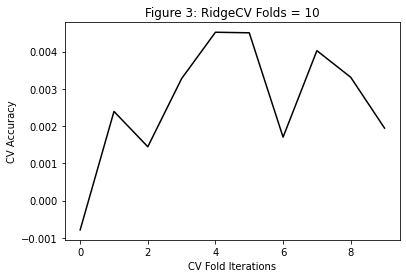

In [47]:
ridge = plt.plot(np.arange(len(cv_ridge)), 
                    cv_ridge['test_score'], 
                    '-0')
plt.title('Figure 3: RidgeCV Folds = 10')
plt.xlabel('CV Fold Iterations')
plt.ylabel('CV Accuracy')
plt.show()

According to the above diagram we can assume that the best cv fold value should be 4. 

#### Discussion of the Model Results


Although we choose 4 as the best cv fold value, it still shows a extremely low prediction scores on the testing sets ($R^2$ value is nearly 0). This shows there is very weak correlation between our predictors and response variables. Meaning, there is little to no relationship between economic family investment income (EFINVA), and the family size (EFSIZE), and the economic family's major income earner (EFMJIE).

### Second Model: KNN-Classification

We hypothesize that our model's weakness may be due to the exclusive use of categorical and low range discrete variables. Since our continuous options (EFATINC) and (ATINC) will not be suitable predictors for our response variable in this case, we can change the model to a classification. Building a model that predicts whether or not the economic family made investment profit may be a better method to investigate the relationship given the predictor variables we are working with. Therefore we convert our response variable into the new variable "EFINVA_Made_Money".

In [48]:
# Wrangling
processed['EFINVA_Made_Money'] = np.array(processed['EFINVA']) > processed['EFINVA'].median()

/var/folders/z5/102n99n926x7011cmbz3_q7w0000gn/T/ipykernel_37660/3311518212.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed['EFINVA_Made_Money'] = np.array(processed['EFINVA']) > processed['EFINVA'].median()


##### Table 6: Processed Dataframe with Family Income Column Converted to Boolean Values for Classification

In [49]:
processed

,EFINVA,EFSIZE,EFMJIE,EFINVA_Made_Money
0,375,4,2,True
1,375,4,2,True
2,375,4,2,True
3,375,4,1,True
4,850,2,1,True
...,...,...,...,...
92282,1725,2,1,True
92283,0,7,1,False
92284,0,7,2,False
92290,0,2,1,False


The same splitting methodology has been applied here as in the regression model. 

In [50]:
train_2, test_2 = train_test_split(processed, test_size = 0.3, random_state=123)
X_train_2, Y_train_2, X_test_2, Y_test_2 = split_drop(processed, 0.3, 123, "EFINVA_Made_Money")

Next, we tune the model to find the best value of K neighbors.

In [51]:
param_grid = {"n_neighbours": np.arange(1,50,5)}
results_df = KNN_tuning(preprocessor,X_train_2,Y_train_2,param_grid)

##### Table 7: Training Score and Cross Validation Score for Various Values of K used in KNN-Classification

In [52]:
results_df

,n_neighbours,mean_train_score,mean_cv_score
0,1,0.488917,0.488552
1,6,0.570205,0.569617
2,11,0.532548,0.532051
3,16,0.561221,0.562111
4,21,0.536832,0.538040
5,26,0.553620,0.554795
6,31,0.561159,0.560159
7,36,0.564883,0.563476
8,41,0.564784,0.563874
9,46,0.573517,0.572479


##### Figure 4: KNN Tuning Results

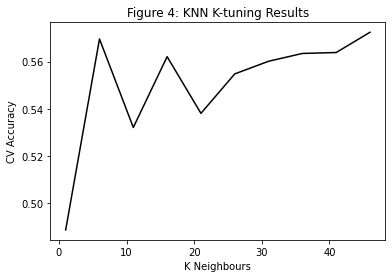

In [53]:
elbow_plt = plt.plot(results_df['n_neighbours'], 
                    results_df['mean_cv_score'], 
                    '-0')
plt.title('Figure 4: KNN K-tuning Results')
plt.xlabel('K Neighbours')
plt.ylabel('CV Accuracy')
plt.show()

The reverse elbow plot shows an optimal K value of 26. Even though a higher CV score is obtained at K=16, this is likely just due to chance. K=26 is a better optimal value since the CV score remains relatively stable past K=26. It shows a mean cross validation score of 56.4% which is a very good estimate for our testing score (see below). 

#### Testing Score

In [54]:
pipe_final = make_pipeline(preprocessor, KNeighborsClassifier(n_neighbors=26))
pipe_final.fit(X_train_2, Y_train_2)
pipe_final.score(X_test_2, Y_test_2)

0.5572704758535291

The model shows an accuracy of 56.38 percent on the testing data, which is very slightly better than arbitrary guessing.

#### Classification Results Visualization

In [55]:
predictions_df = pd.DataFrame(data=pipe_final.predict(X_test_2),
                             columns = ["Pred_EFINVA_Made_Money"],
                             index=test_2.index)

true_and_pred = pd.concat([test_2, predictions_df], axis=1)

##### Table 8: Dataframe of testing data with actual target and predicted target 

In [56]:
true_and_pred.drop(columns=['EFINVA'])

,EFSIZE,EFMJIE,EFINVA_Made_Money,Pred_EFINVA_Made_Money
20152,4,1,True,False
77329,1,1,True,False
59554,2,1,True,True
52005,1,1,False,False
49898,3,2,False,False
...,...,...,...,...
51206,2,1,False,True
83647,2,1,True,True
35202,1,1,False,False
52417,1,1,False,False


In [57]:
grouped_true_pred = true_and_pred.groupby(['EFSIZE','EFMJIE', 'EFINVA_Made_Money', 'Pred_EFINVA_Made_Money']).size().reset_index()
grouped_true_pred = pd.DataFrame(grouped_true_pred)
grouped_true_pred = grouped_true_pred.rename(columns={0:"counts"})

##### Table 9: Grouped dataframe with counts  

In [58]:
grouped_true_pred

,EFSIZE,EFMJIE,EFINVA_Made_Money,Pred_EFINVA_Made_Money,counts
0,1,1,False,False,2792
1,1,1,True,False,1304
2,2,1,False,True,2403
3,2,1,True,True,2102
4,2,2,False,False,2160
5,2,2,True,False,2015
6,3,1,False,False,1071
7,3,1,True,False,596
8,3,2,False,False,1343
9,3,2,True,False,905


##### Figure 5: Confusion Matrix

/Users/harryzhang/miniforge3/envs/DSCI-310-Group-10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


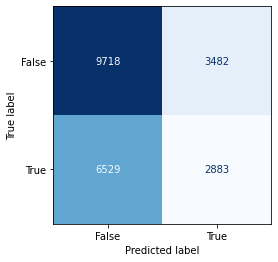

In [59]:
plot_confusion_matrix(pipe_final, X_test_2, Y_test_2, cmap=plt.cm.Blues, colorbar=False)

/Users/harryzhang/Desktop/DSCI-310-Group-10/src/analysis/inv_outcome_plot.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  list_of_fam_size_df[i][counts_col] = list_of_fam_size_df[i][counts_col].div(np.sum(list_of_fam_size_df[i][counts_col]))


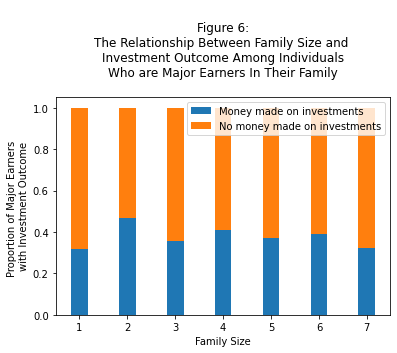

In [60]:
title_1 = """
Figure 6:
The Relationship Between Family Size and 
Investment Outcome Among Individuals
Who are Major Earners In Their Family
"""
ylabel_1 = """Proportion of Major Earners 
with Investment Outcome"""

plot1 = inv_outcome_plot.inv_outcome_plot(grouped_true_pred,
                                 'EFSIZE',
                                 'EFMJIE',
                                 'EFINVA_Made_Money',
                                 'counts',
                                 True,
                                 title_1,
                                 ylabel_1)

/Users/harryzhang/Desktop/DSCI-310-Group-10/src/analysis/inv_outcome_plot.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  list_of_fam_size_df[i][counts_col] = list_of_fam_size_df[i][counts_col].div(np.sum(list_of_fam_size_df[i][counts_col]))


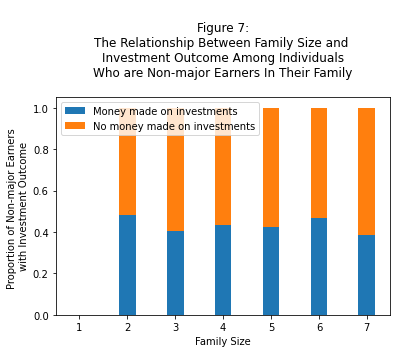

In [61]:
title_2 = """
Figure 7:
The Relationship Between Family Size and 
Investment Outcome Among Individuals
Who are Non-major Earners In Their Family
"""
ylabel_2 = """Proportion of Non-major Earners 
with Investment Outcome"""

plot2 = inv_outcome_plot.inv_outcome_plot(grouped_true_pred,
                                 'EFSIZE',
                                 'EFMJIE',
                                 'EFINVA_Made_Money',
                                 'counts',
                                 False,
                                 title_2,
                                 ylabel_2)

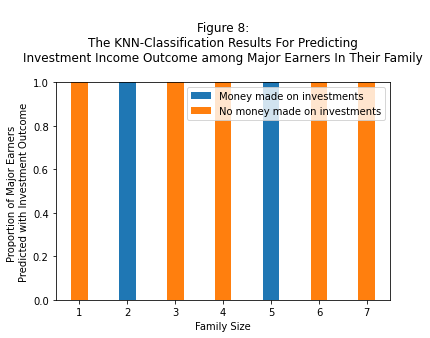

In [62]:
title_3 ="""
Figure 8:
The KNN-Classification Results For Predicting
Investment Income Outcome among Major Earners In Their Family
"""
ylabel_3 = """Proportion of Major Earners 
Predicted with Investment Outcome"""

plot3 = inv_outcome_plot.inv_outcome_plot(grouped_true_pred,
                                 'EFSIZE',
                                 'EFMJIE',
                                 'Pred_EFINVA_Made_Money',
                                 'counts',
                                 True,
                                 title_3,
                                 ylabel_3)

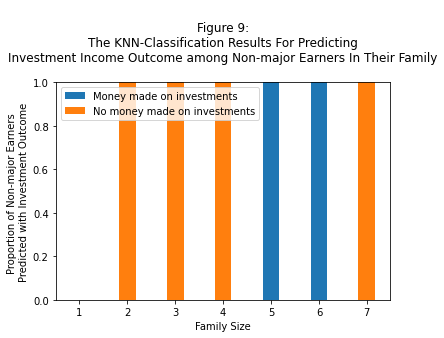

In [63]:
title_4 ="""
Figure 9:
The KNN-Classification Results For Predicting
Investment Income Outcome among Non-major Earners In Their Family
"""
ylabel_4 = """Proportion of Non-major Earners 
Predicted with Investment Outcome"""

plot4 = inv_outcome_plot.inv_outcome_plot(grouped_true_pred,
                                 'EFSIZE',
                                 'EFMJIE',
                                 'Pred_EFINVA_Made_Money',
                                 'counts',
                                 False,
                                 title_4,
                                 ylabel_4)

#### Discussion of Plot Results

* Figures 6 and 7 show the actual results from the test data for investment income outcomes among major earners and non major earners respectively. Both figures show families of size 2, 4 and 6 to have the largest proportions of people making money from investments while families of 7 have the lowest proportions of individuals making money. However, among the non-major income earners, the proportions of individuals making money is generally slightly higher. Nevertheless, The percentages either breaking even or losing money on their investments is larger among a majority of the family sizes in both cases. A key difference is also present among non major earners where families of 1 are non existant. This is logical within this context since a family consisting of one person automatically makes that person the major earner.

* Figures 8 and 9 show the predicted results from the KNN-classification algorithm deployed on the test data for major earners and non major earners respectively. The results are not extremely surprising given the ~57% accuracy obtained. The KNN-classification model seems to be unable to distinguish between the different family sizes since it classifies all individuals within a specific family size as the same.


## Discussion of Overall Results:

Using two different models, we concluded that the relationship between the Economic Family's Investment Income, size, and major income source is very weak. This was unexpected, as the original assumption of high correlation between the variables was disproven.

The relative improvement in the accuracy of the KNN classification model compared to the Regression model may indicate that the predictor variables are better at predicting whether or not the economic family made profits through investment, than they are at predicting the magnitude of said profits/losses.

The design decision to eliminate the Economic Family's Income After Tax from the list of predictor variables, due to low correlation, may have negatively affected the accuracy of both models. Prior to starting the analysis, it was assumed that it would be too collinear with the response variable. However, the correlation coefficients showed this not to be the case. A possible explanation is that the economic family's income before tax is what suffers from this multicollinearity with the investment income, due to the latter being one of the many contributing incomes to the sum that makes it up. The removal of tax may offset this multicollinearity to a strong enough degree that it would make for better predictive models, and the degree of this change may be an interesting topic for a future study. 

A further point of discussion is the age of the dataset, as the data was collected prior to the cryptocurrency boom in 2017. Some of the data regarding the relationships surrounding the investment income (direct or indirect) may be outdated.

In the future, Data Scientists studying investment income of Canadian Families may refrain from dedicating significant resources to using the family's size and major source of income as possible predictors, due to the lack of evidence for a relationship between them exemplified through the analysis. 

Additionally, it may encourage more studies surrounding investment income of individuals as opposed to that of families, which may lead to different results due to variables such as the investor's highest education level and sex being more relevant. It may also better fit the investor's status as the major income earner of the economic family, as its lack of relationship with the family's investment income may indicate more suitability in a study about the individual rather than the family 

## References:

[1] Data Liberation Initiative (DLI) , Statistics Canada. (2020). Canadian Income Survey. Nesstar. http://dli-idd-nesstar.statcan.gc.ca.ezproxy.library.ubc.ca/webview/index.jsp?v=2&node=0&submode=ddi&study=https%3A%2F%2F142.206.64.59%3A443%2Fobj%2FfStudy%2FCIS-72M0003-E-2017-Annual&mode=documentation&top=yes

[2] Industry News, Wealth Professional, More than half of Canadians plan to own shares by year-end (2021). https://www.wealthprofessional.ca/news/industry-news/more-than-half-of-canadians-plan-to-own-shares-by-year-end/359479

[3] Benefits Canada, Millennials invest early, think long term (2013). https://www.benefitscanada.com/news/bencan/millennials-invest-early-think-long-term/

[4] KPMG in Canada Blog , The rise of the family office in Canada (2021). https://home.kpmg/ca/en/blogs/home/posts/2021/06/the-rise-of-the-family-office-in-canada.html

[5] Statistics Canada, Total Income of the Economic Family. https://www23.statcan.gc.ca/imdb/p3Var.pl?Function=DEC&Id=103378